In [12]:
! pip install qiskit

In [13]:
! pip install qiskit-machine-learning

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


In [15]:
df = pd.read_csv('Thesis IBM Dataset.csv')
df.head()

,Date,Time,Temperature(C),Feel likes(C),Chance of Prec.(%),Humidity(%),Visibity(km),Pressure(hPa),State,Real State,Rain,Cloudy,Sunny,Fog
0,27-06-2023,08:00,27,32,21,87,3.0,1003,Cloudy,Cloudy,0.0,1,0,0
1,27-06-2023,09:00,27,32,22,86,9.0,1003,Cloudy,Cloudy,0.0,1,0,0
2,27-06-2023,10:00,28,34,23,90,3.0,1003,Cloudy,Rain,1.0,1,0,0
3,27-06-2023,11:00,28,33,30,85,9.0,1003,Isolated Thunderstroms,Rain,1.0,1,0,0
4,27-06-2023,12:00,27,32,53,90,9.0,1003,Rain,Sunny,0.0,0,1,0


In [16]:
df.drop(columns=['Date'], inplace=True)
#df.drop(columns=['Temperature(C)'], inplace=True)



In [17]:
df.drop(columns=['Time', 'State','Real State'], inplace=True)

In [18]:
for col in df.columns:
    if (col == 'Rain'):
       
        df[col] = np.where(df[col] == 0.0, 0, 1)
df

,Temperature(C),Feel likes(C),Chance of Prec.(%),Humidity(%),Visibity(km),Pressure(hPa),Rain,Cloudy,Sunny,Fog
0,27,32,21,87,3.0,1003,0,1,0,0
1,27,32,22,86,9.0,1003,0,1,0,0
2,28,34,23,90,3.0,1003,1,1,0,0
3,28,33,30,85,9.0,1003,1,1,0,0
4,27,32,53,90,9.0,1003,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4499,20,20,1,77,8.0,1014,0,0,1,0
4500,19,19,1,80,14.0,1015,0,0,1,0
4501,19,19,2,82,14.0,1015,0,0,1,0
4502,18,18,2,83,14.0,1015,0,0,1,0


In [19]:
labels = df['Fog'].values

    # get the values from all other columns of the subset and store them in X_subset
features = df.iloc[:, :-1].values

In [20]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

In [21]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.75, random_state=32
)

In [22]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

In [23]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.98
Classical SVC on the test dataset:     0.98


In [24]:
! pip install pylatexenc

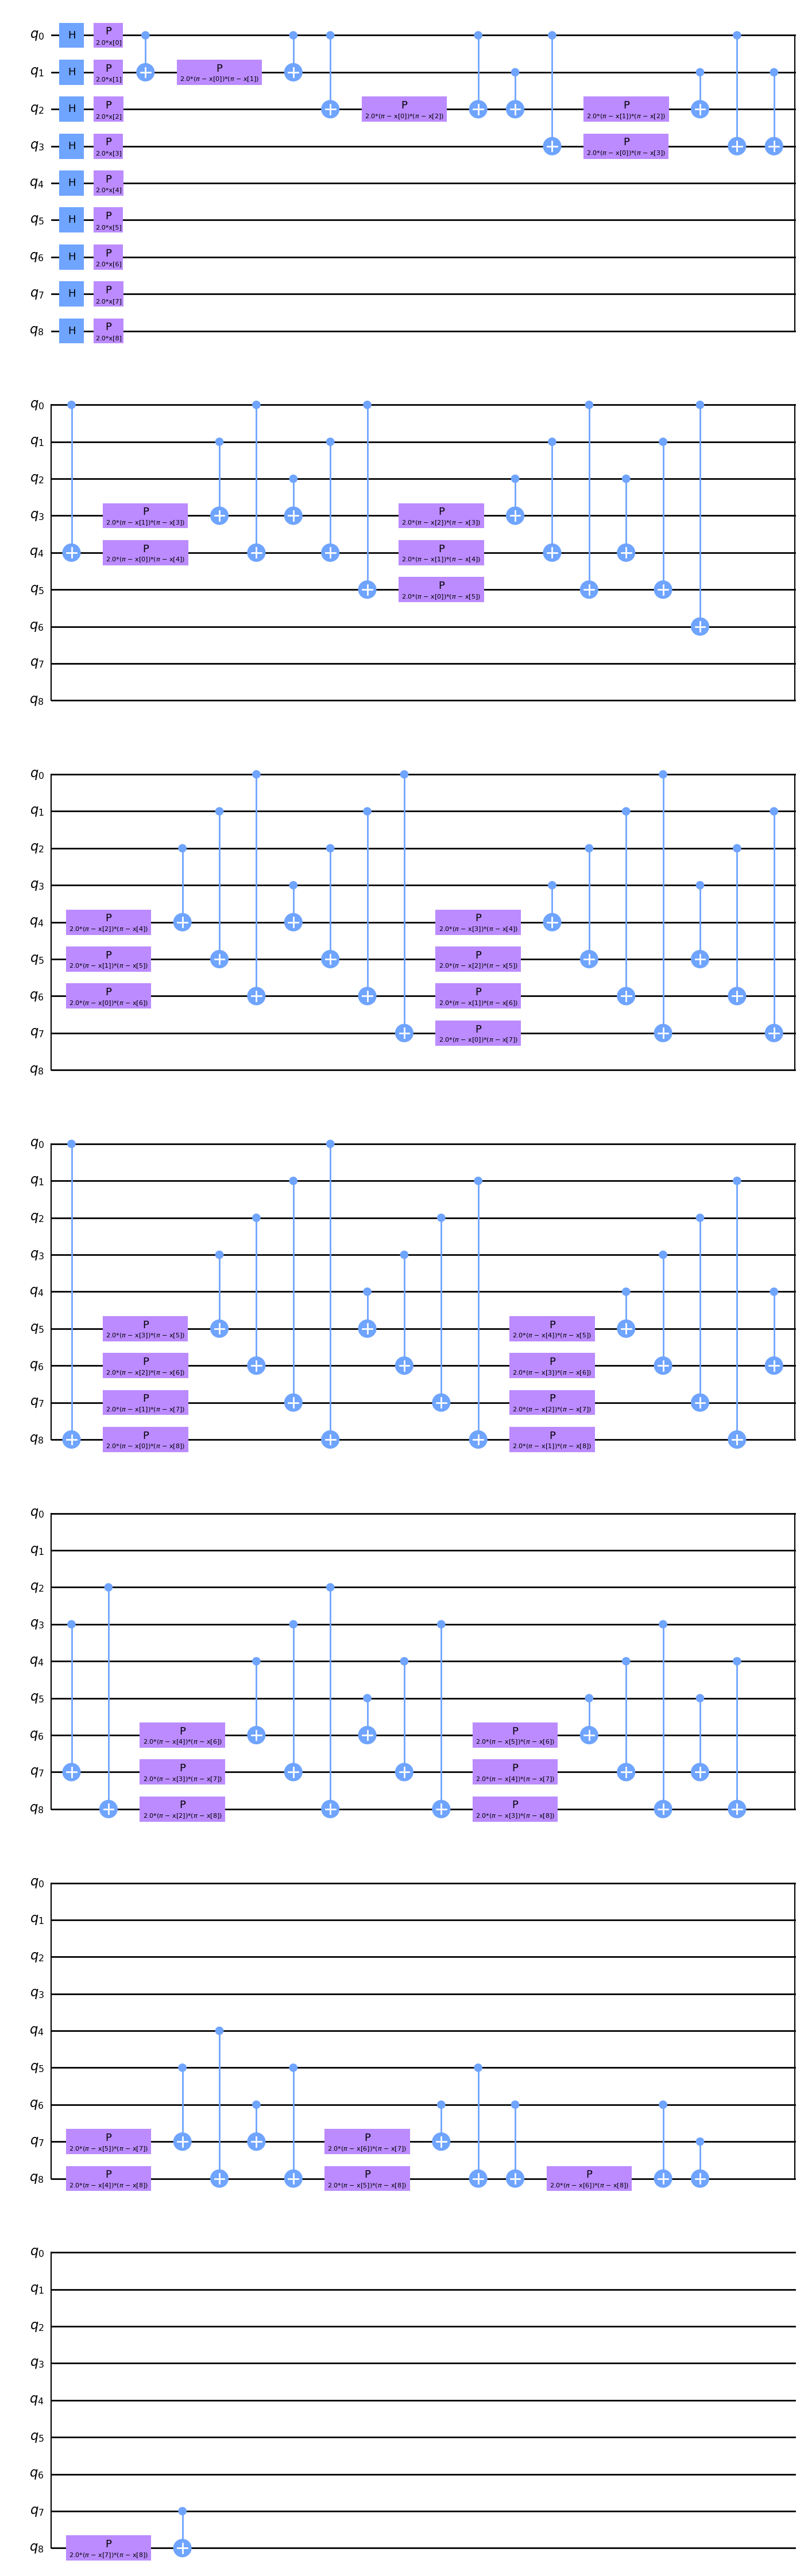

In [25]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

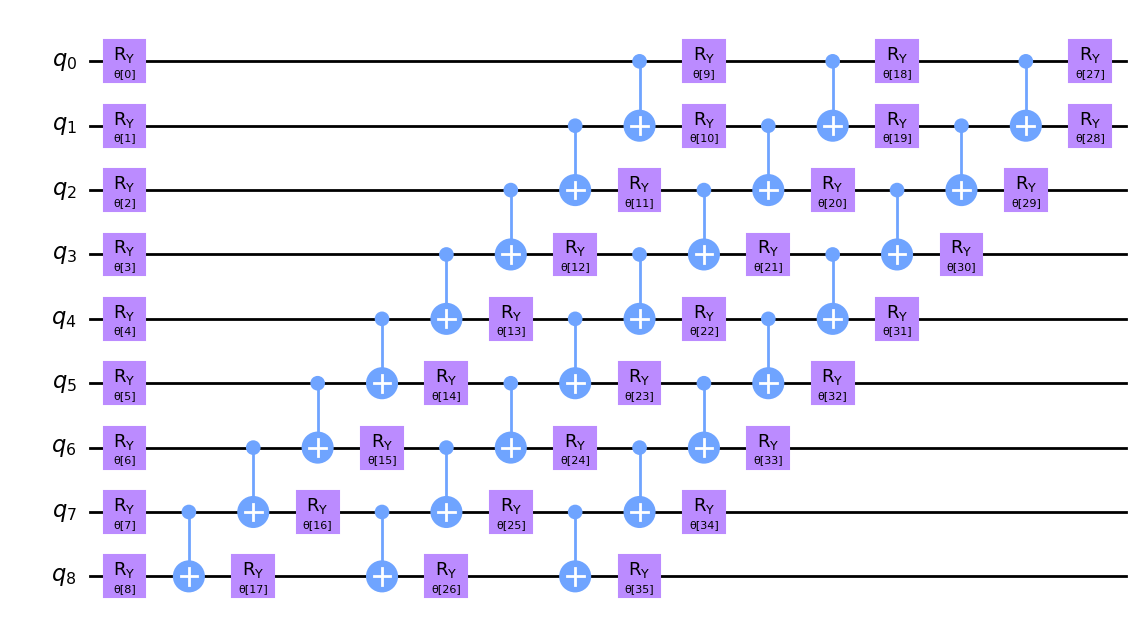

In [26]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [27]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, QNSPSA,AQGD

optimizer = COBYLA(maxiter=50)

In [28]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [29]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration for Fog (IBM)")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

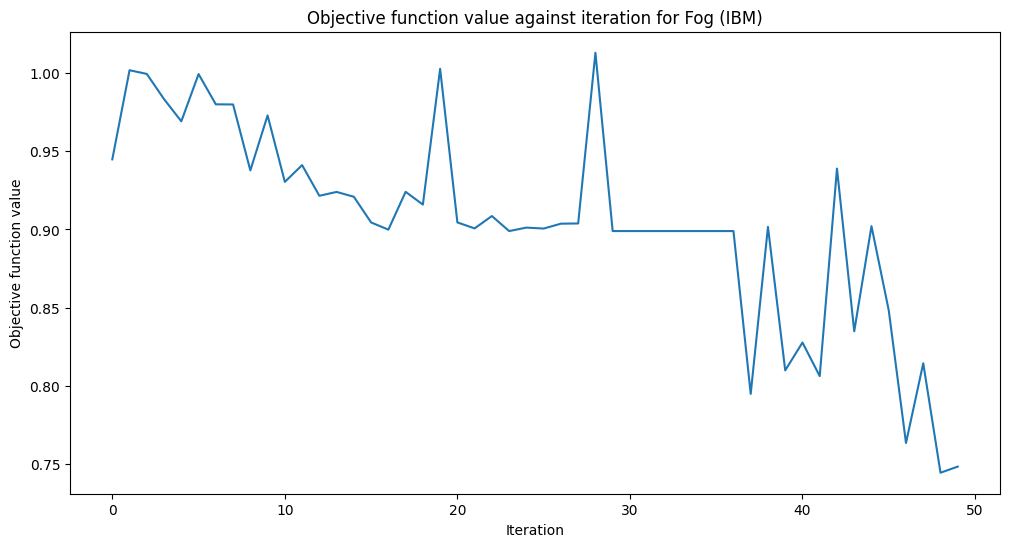

Training time: 15947 seconds


In [30]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [31]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.96
Quantum VQC on the test dataset:     0.96


In [32]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

In [33]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.75, random_state=32
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.98
Classical SVC on the test dataset:     0.98


In [34]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [35]:
optimizer = COBYLA(maxiter=50)

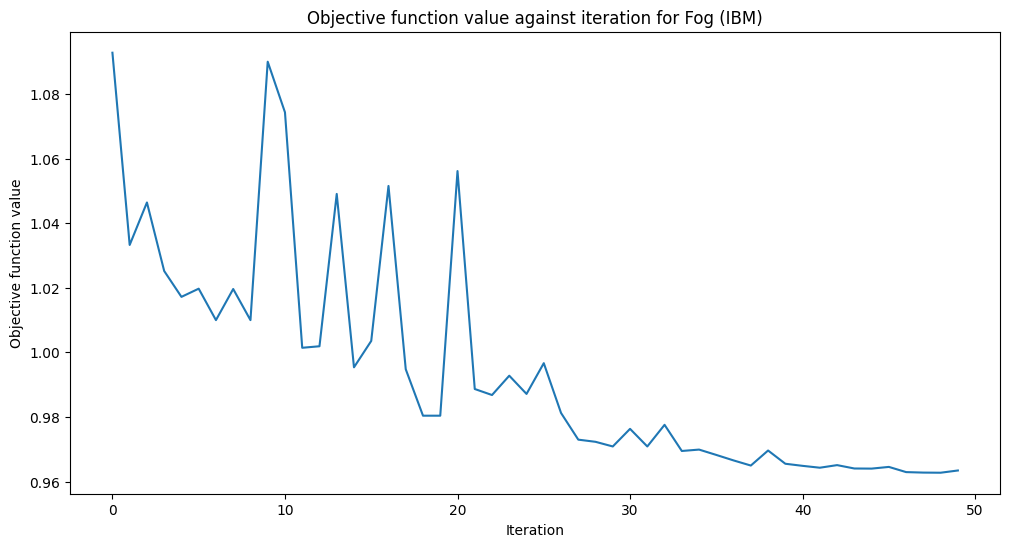

Training time: 1179 seconds


In [36]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [37]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.66
Quantum VQC on the test dataset using RealAmplitudes:     0.67


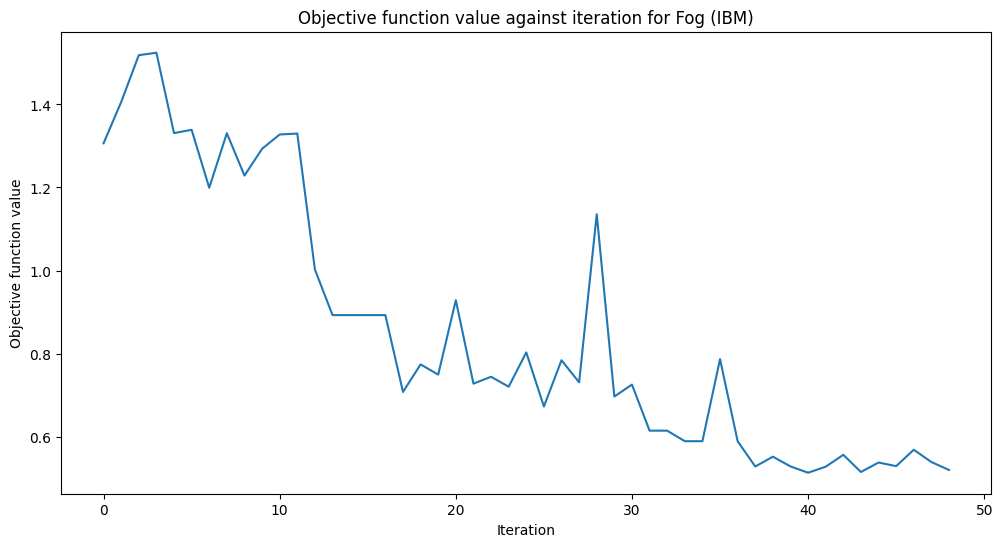

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=50)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

In [ ]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")